In [1]:
import os
import yaml

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np


In [2]:
sns.set_context("paper")
sns.set_palette("colorblind")

In [3]:
def get_all_file_paths(directory, contains=None):
    file_paths = []  # List to store all file paths
    for root, _, files in os.walk(directory):
        for file in files:
            # Create full path by joining root and file
            if(contains is not None):
                if contains in file:
                    file_paths.append(os.path.join(root, file))
            else:
                file_paths.append(os.path.join(root, file))
    return file_paths

In [4]:
def get_timestamp(string: str):
    return string.split('_')[-1].split('.')[0]

In [5]:
def reshape_data(df: pd.DataFrame):
    df['loss'] = df['loss'].replace('CE Loss', 'Standart T5')
    df['loss'] = df['loss'].replace('CE and MSE Loss', 'Standard + NTL-MSE')
    df['loss'] = df['loss'].replace('CE and Wassserstein Loss', 'Standard + NTL-WAS')
    df['loss'] = df['loss'].replace('CE and Abs Diff NTL Loss', 'Standard + NTL-ABS-DIFF')

    df.rename(columns={'loss': 'Loss'}, inplace=True)
    df.rename(columns={'standalone': 'Standalone'}, inplace=True)
    df.rename(columns={'forward pass': 'Forward pass'}, inplace=True)
    df.rename(columns={'training step': 'Training step'}, inplace=True)

    df_long = df.melt(id_vars="Loss", var_name="benchmark", value_name="time")
    df_long["mean_time"] = df_long["time"].apply(lambda x: x.split(",")[0][1:]).astype(float)
    df_long["error"] = df_long["time"].apply(lambda x: x.split(",")[1][1:-1]).astype(float)
    del df_long["time"]
    return df_long

In [6]:
def get_df_by_number_share(directory):
    file_paths = get_all_file_paths(directory, contains='.csv')
    dfs = {}

    for file_path in file_paths:
        print(file_path)
        timestamp = get_timestamp(file_path)
        config_file = get_all_file_paths(directory, contains = timestamp + '.stored_yaml')[0]
        with open(config_file, 'r') as file:
            config = yaml.load(file, Loader=yaml.FullLoader)
        number_share = config['forward pass benchmark']['number_share']
        dfs[number_share] = reshape_data(pd.read_csv(file_path))

    dfs = dict(sorted(dfs.items()))

    return dfs


In [7]:
dfs = get_df_by_number_share('gpu/')

gpu/benchmark_results_173445291367.csv
gpu/benchmark_results_173445756144.csv
gpu/benchmark_results_173446236707.csv
gpu/benchmark_results_173445994530.csv
gpu/benchmark_results_173444868654.csv
gpu/benchmark_results_173446479231.csv
gpu/benchmark_results_173446724990.csv
gpu/benchmark_results_173446993997.csv
gpu/benchmark_results_173444686296.csv
gpu/benchmark_results_173445072449.csv
gpu/benchmark_results_173445519354.csv


In [8]:
dfs[0.1].head()

,Loss,benchmark,mean_time,error
0,Standart T5,Standalone,0.013425,0.000006
1,Standard + NTL-MSE,Standalone,0.013855,0.000011
2,Standard + NTL-WAS,Standalone,0.047136,0.000020
3,Standard + NTL-ABS-DIFF,Standalone,0.013710,0.000009
4,Standart T5,Forward pass,0.219285,0.009646


In [9]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def combined_plots(df):
    # Set Seaborn style for publication-ready visuals
    sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)

    # Unique benchmarks and loss functions
    benchmarks = df["benchmark"].unique()
    loss_functions = df["Loss"].unique()

    # Define colors using Seaborn palette
    palette = sns.color_palette("deep")
    color_map = {loss: color for loss, color in zip(loss_functions, palette)}

    # Set up the plot with one subplot per benchmark
    fig, axes = plt.subplots(1, len(benchmarks), figsize=(5 * len(benchmarks), 6), sharey=True)

    # Calculate the overall tallest bar for consistent buffer across all subplots
    max_runtime = (df["mean_time"] + df["error"]).max() * 1_000

    # Plot for each benchmark
    for i, (benchmark, ax) in enumerate(zip(benchmarks, axes)):
        subset = df[df["benchmark"] == benchmark]
        
        # Bar positions
        x_positions = np.arange(len(subset))
        
        # Plot bars with error bars, using different colors for each loss function
        for j, (loss, mean_time, error) in enumerate(zip(subset["Loss"], subset["mean_time"], subset["error"])):
            ax.bar(x_positions[j], mean_time * 1_000,  # Scale mean_time to ms
                   yerr=error * 1_000,  # Scale error to ms
                   capsize=5, color=color_map[loss], alpha=0.8, label=loss if i == 0 else "")

        # Customize each subplot
        ax.set_xticks(x_positions)
        ax.set_xticklabels(subset["Loss"], rotation=45, ha="right", fontsize=12)
        ax.set_title(benchmark, fontsize=16, weight="bold")
        if i == 0:
            ax.set_ylabel("Time (ms)", fontsize=14)
        
        # Add buffer zone above tallest bar
        ax.set_ylim(0, max_runtime * 1.2)  # Add 20% buffer above the tallest bar

    # Add a single legend outside the plot
    handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[loss]) for loss in loss_functions]
    fig.legend(handles, loss_functions, title="Loss Function", loc="upper center", bbox_to_anchor=(0.5, 1.05), ncol=4, fontsize=12)

    # Adjust layout and save the figure
    plt.tight_layout(rect=[0, 0, 1, 0.95])  # Adjust rect to make room for the legend
    plt.savefig("combined_benchmark_plots.png", dpi=300, bbox_inches="tight")

    # Show the plot
    plt.show()

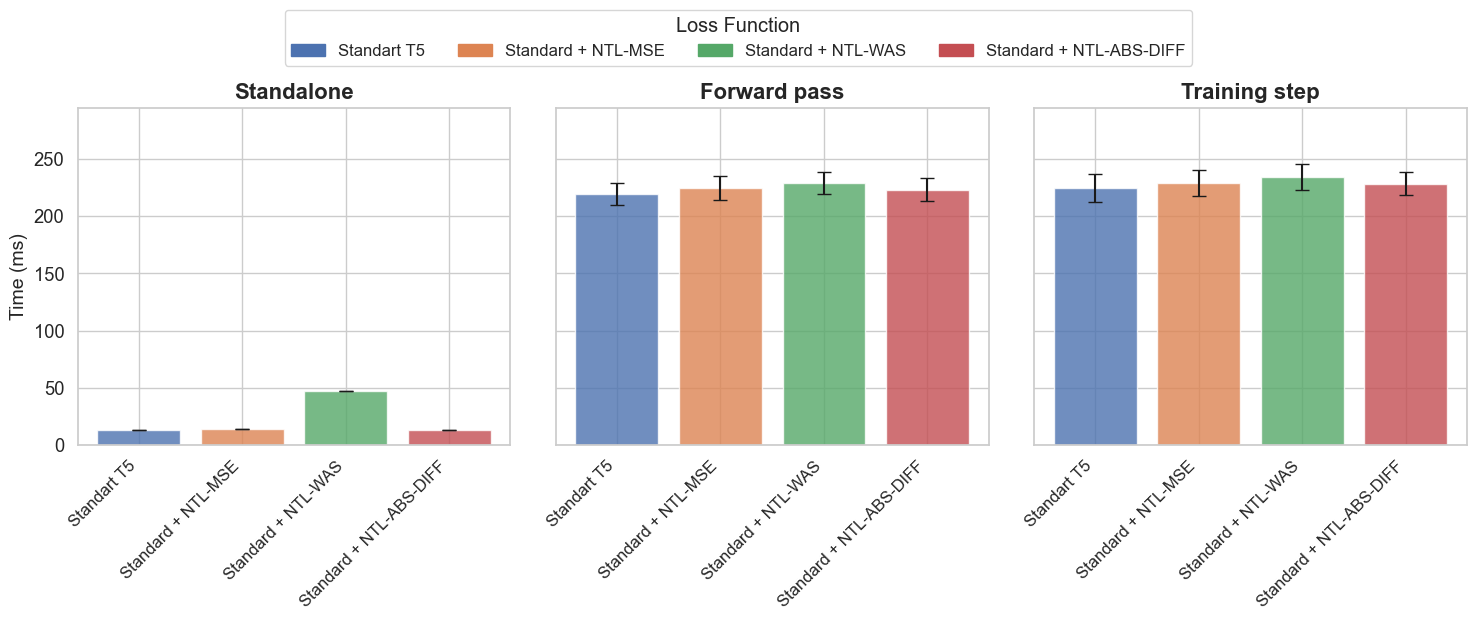

In [10]:
combined_plots(dfs[0.1])

In [22]:
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

def separate_plots(df):
    # Set Seaborn style for publication-ready visuals
    sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)
    
    # Unique benchmarks and loss functions
    benchmarks = df["benchmark"].unique()
    loss_functions = df["Loss"].unique()
    
    # Seaborn color palette
    palette = sns.color_palette("deep")
    color_map = {loss: color for loss, color in zip(loss_functions, palette)}
    
    # Plot for each benchmark separately
    for benchmark in benchmarks:
        # Subset the dataframe for the current benchmark
        subset = df[df["benchmark"] == benchmark]
        
        # Bar positions
        x_positions = np.arange(len(subset))
        
        # Calculate the maximum value for the buffer zone
        max_runtime = (subset["mean_time"] + subset["error"]).max() * 1_000  # Add error to find the tallest bar
        
        # Create the plot
        plt.figure(figsize=(10, 8))
        for j, (loss, mean_time, error) in enumerate(zip(subset["Loss"], subset["mean_time"], subset["error"])):
            plt.bar(x_positions[j], mean_time * 1_000,  # Scale mean_time to milliseconds
                    yerr=error * 1_000,  # Scale error to milliseconds
                    capsize=5, color=color_map[loss], alpha=0.8, label=loss)
        
        # Customize plot
        plt.xticks(x_positions, subset["Loss"], rotation=45, ha="right", fontsize=12)
        plt.title(f"Benchmark: {benchmark}", fontsize=18, weight="bold")
        plt.xlabel("Loss Function", fontsize=14)
        plt.ylabel("Time (ms)", fontsize=14)
        plt.yticks(fontsize=12)
        
        # Adjust y-axis limit to create a buffer zone
        plt.ylim(0, max_runtime * 1.)  # Add 20% buffer above the tallest bar
        
        # Add legend (outside the loop to avoid repetition)
        handles = [plt.Rectangle((0, 0), 1, 1, color=color_map[loss]) for loss in loss_functions]
        plt.legend(handles, loss_functions, title="Loss Function", fontsize=12, loc="upper left")
        
        # Save the plot as a high-resolution image
        plt.tight_layout()
        plt.savefig(f"benchmark_{benchmark.replace(' ', '_')}.png", dpi=300)
        
        # Show the plot
        plt.show()


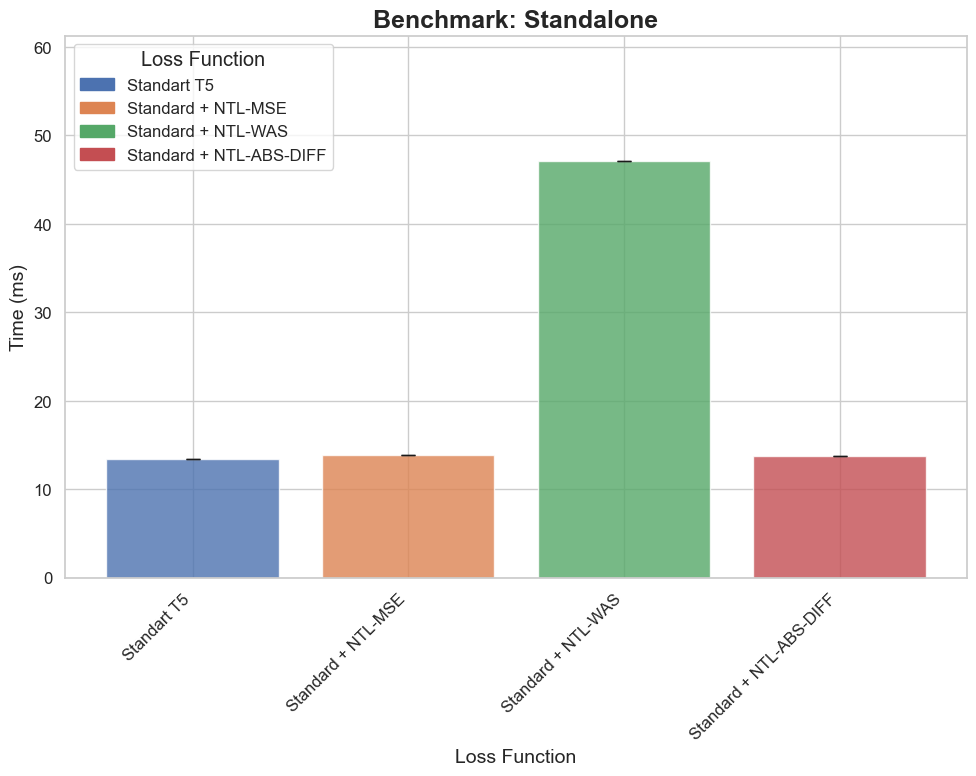

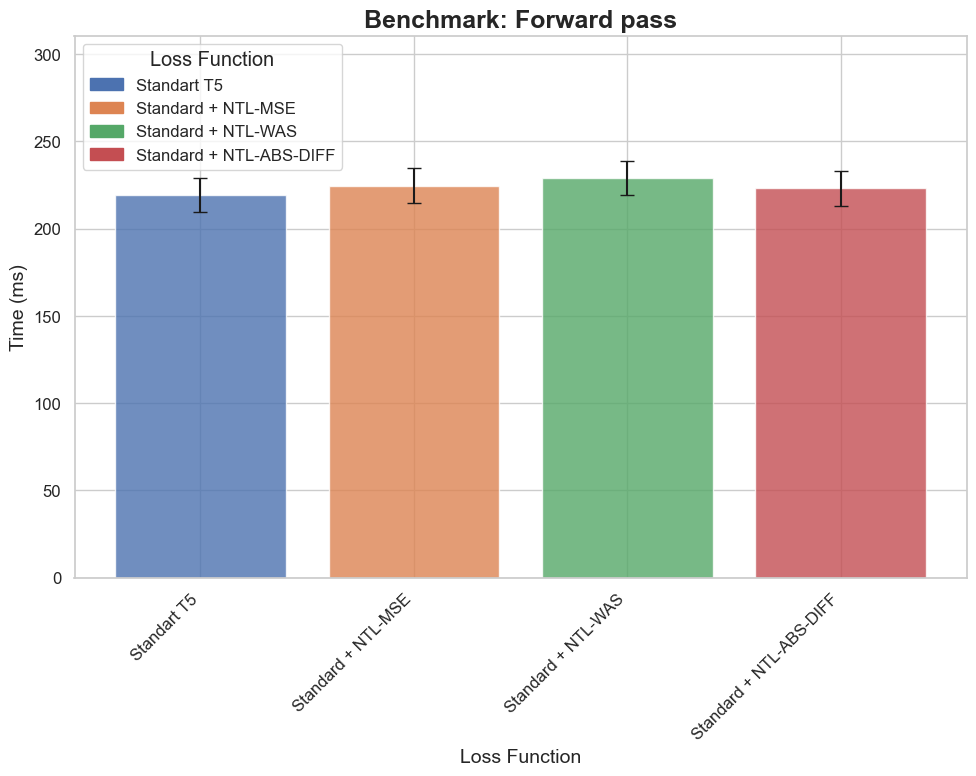

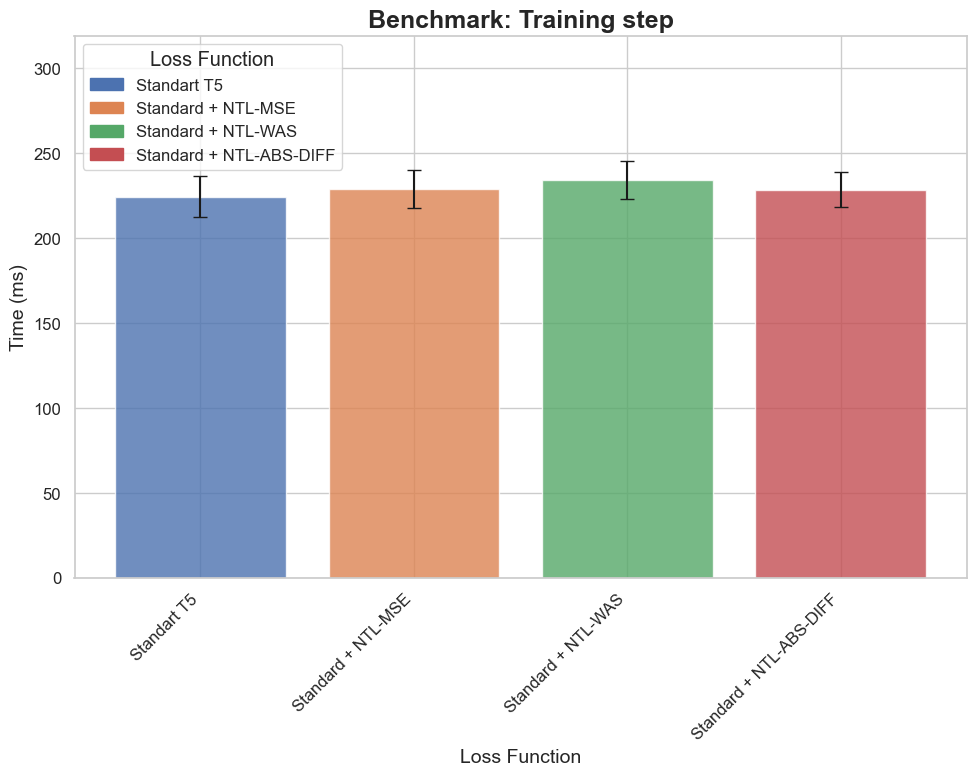

In [12]:
separate_plots(dfs[0.1])

In [40]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

def plot_number_share(data):
    # Set Seaborn style
    sns.set_theme(style="whitegrid", palette="muted", font_scale=1.2)
    
    # Extract unique benchmarks
    benchmarks = data[0.1]["benchmark"].unique()
    loss_functions = data[0.1]["Loss"].unique()

    # Define Seaborn color palette for different losses
    palette = sns.color_palette("deep")  # Seaborn default colors
    loss_colors = {'Standart T5': palette[0], 
                   'Standard + NTL-MSE': palette[1], 
                   'Standard + NTL-WAS': palette[2], 
                   'Standard + NTL-ABS-DIFF': palette[3]}
    
    # Iterate over each benchmark to create a plot
    for benchmark in benchmarks:
        plt.figure(figsize=(10, 8))
        
        # Define unique losses and positions for bars
        all_losses = ['Standart T5', 'Standard + NTL-MSE', 'Standard + NTL-WAS', 'Standard + NTL-ABS-DIFF']
        x_positions = np.arange(len(data))  # One position for each number share
        
        # Bar width
        bar_width = 0.2
        
        # Initialize a variable to find the maximum y value
        max_runtime = 0

        # Loop through each loss to plot bars
        for i, loss in enumerate(all_losses):
            mean_times = []
            std_devs = []
            for portion, df in data.items():
                # Filter data for the current loss and benchmark
                subset = df[(df['benchmark'] == benchmark) & (df['Loss'] == loss)]
                mean_time_ms = subset['mean_time'].values[0] * 1_000  # Scale to ms
                error_ms = subset['error'].values[0] * 1_000          # Scale error to ms
                mean_times.append(mean_time_ms)
                std_devs.append(error_ms)
                
                # Update max runtime for scaling the y-axis
                max_runtime = max(max_runtime, mean_time_ms + error_ms)
            
            # Plot the bars with error bars (standard deviation)
            plt.bar(x_positions + i * bar_width, mean_times, 
                    yerr=std_devs,  # Add error bars
                    capsize=4,      # Add caps on error bars
                    width=bar_width, color=loss_colors[loss], label=loss, alpha=0.9)
        
        # Add buffer zone above the tallest bar
        plt.ylim(0, max_runtime * 1.4)  # Add 20% buffer

        # Configure plot
        plt.title(f"Runtime for Benchmark: {benchmark}", fontsize=18, weight='bold')
        plt.xlabel("Number Share", fontsize=14)
        plt.ylabel("Mean Runtime (ms)", fontsize=14)
        plt.xticks(ticks=x_positions + bar_width * (len(all_losses)-1) / 2, 
                   labels=[str(k) for k in data.keys()], fontsize=12)
        plt.yticks(fontsize=12)

        # Add legend
        handles = [plt.Rectangle((0, 0), 1, 1, color=loss_colors[loss]) for loss in loss_functions]
        plt.legend(handles, loss_functions, title="Loss Function", fontsize=12, loc="upper left")
        
        # Tweak grid and layout
        plt.grid(axis='y', linestyle='--', alpha=0.7)
        plt.tight_layout(rect=[0, 0, 1, 0.9])  # Adjust layout to fit the legend
        
        # Save plot as high-resolution image for a paper
        plt.savefig(f"runtime_benchmark_{benchmark.replace(' ', '_')}.png", dpi=300, bbox_inches="tight")
        
        # Show the plot
        plt.show()


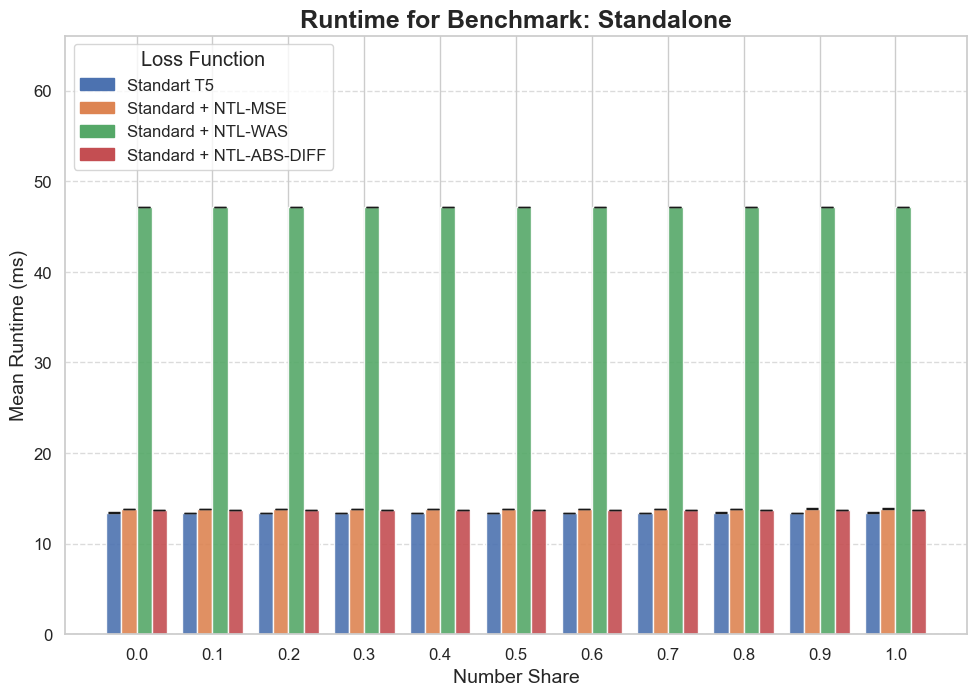

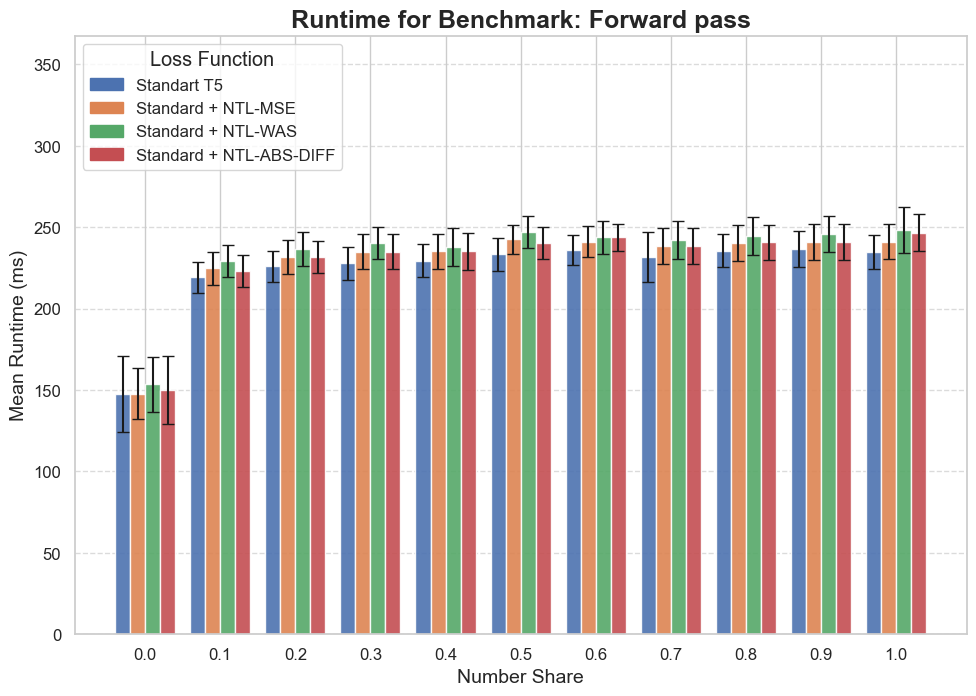

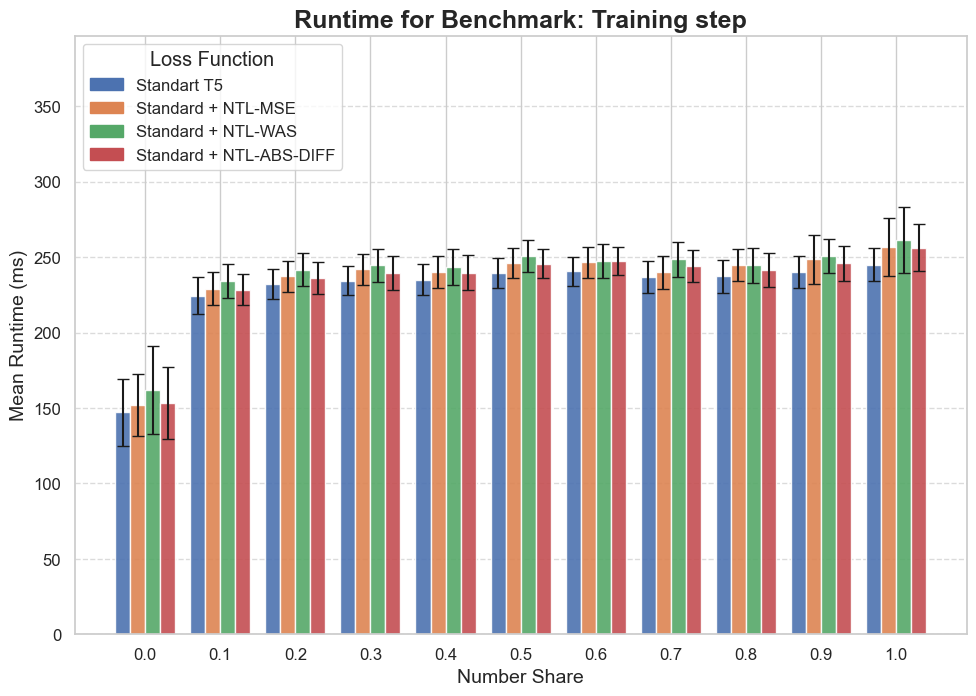

In [41]:
plot_number_share(dfs)